In [1]:
import numpy as np               
import matplotlib.pyplot as plt  
import pandas as pd
from sklearn import tree
from sklearn import ensemble
from sklearn import datasets 

# 決定木

In [2]:
d = datasets.load_wine()              # wineデータ読込み
dt = tree.DecisionTreeClassifier()    # 決定木
dt.fit(d.data, d.target)              # フィッティング
1-dt.score(d.data,d.target)           # トレーニング誤差

0.0

In [3]:
dt.set_params(max_depth=3)            # 木の深さの最大値を設定
dt.fit(d.data, d.target)              # フィッティング
1-dt.score(d.data,d.target)           # トレーニング誤差

0.022471910112359605

In [4]:
import graphviz            # graphviz.Source を使う
# graphvizで決定木を描画
graph = graphviz.Source(tree.export_graphviz(dt,out_file=None))
# graph.render("DTplot")     # 図をファイルに出力

# バギング

In [5]:
# 1,2,3,4,5 の復元抽出(リサンプリング)
np.random.choice(5,5)

array([4, 4, 2, 0, 1])

In [6]:
# 0，1,2,3,4 の非復元抽出
np.random.choice(5,5,replace=False)

array([1, 0, 4, 2, 3])

In [10]:
d = datasets.load_iris()                 # データ読込み
i = np.random.choice(d.data.shape[0],100,replace=False)
ti = np.delete(np.arange(d.data.shape[0]),i)
x,    y = d.data[i,:],   d.target[i]        # トレーニングデータ
tx, ty = d.data[ti,:], d.target[ti]      # テストデータ
ba = ensemble.BaggingClassifier(n_estimators=100)
ba.fit(x,y)                         # バギング(B=100)
1-ba.score(tx,ty)                   # テスト誤差

0.020000000000000018

In [11]:
dt = tree.DecisionTreeClassifier()  # 単独の決定木を学習
dt.fit(x,y)
1-dt.score(tx,ty)                   # テスト誤差

0.020000000000000018

# ランダム・フォレスト

In [13]:
d  = pd.read_csv('data/stagec.csv').values   # データ読込み
xa, ya = np.array(d[:,:6]).astype('float'), d[:,7]
i = ~np.isnan(xa).any(axis=1); xa, ya = xa[i,:], ya[i] # nan 除去
x, y    = xa[:100,:], ya[:100]          # トレーニングデータ
tx, ty = xa[100:,:], ya[100:]          # テストデータ
# ランダムフォレスト：木の数 10
rf = ensemble.RandomForestClassifier(n_estimators=10)
rf.fit(x,y)
1-rf.score(tx,ty)    # テスト誤差

0.08108108108108103

In [14]:
# ランダムフォレスト：木の数 1000
rf.set_params(n_estimators=1000)
rf.fit(x,y)
1-rf.score(tx,ty)    # テスト誤差

0.027027027027026973

In [15]:
dt = tree.DecisionTreeClassifier()      #  決定木
dt.fit(x,y)
1-dt.score(tx,ty)    # テスト誤差

0.054054054054054057

In [16]:
ba = ensemble.BaggingClassifier(n_estimators=10)  # バギング(B=10)
ba.fit(x,y)
1-ba.score(tx,ty)    # テスト誤差

0.027027027027026973

# ブースティング

In [17]:
n = 4000                               # トレーニングデータ数
d = pd.read_csv('data/soldat.csv').values;  # データ読込み
d=np.delete(d,70,1)                    # nanを除去
i  = np.random.choice(len(d),n,replace=False)  
ti = np.delete(np.arange(len(d)), i)           
x, y  = d[i,:71], d[i,71]             # トレーニングデータ
tx, ty = d[ti,:71], d[ti,71]        # テストデータ
T = 1000                                    # ブースティング：ラウンド数
bl = tree.DecisionTreeClassifier(max_depth=1)               # 決定株
# 決定株でアダブーストを実行
ab = ensemble.AdaBoostClassifier(base_estimator=bl, n_estimators=T)
ab.fit(x,y)                                # フィッティング
# 各ラウンドの誤差
ada_tr_err = np.zeros((T,))            
for i, score in enumerate(ab.staged_score(x,y)): 
    ada_tr_err[i] = 1-score                     # トレーニング誤差
ada_te_err = np.zeros((T,))            
for i, score in enumerate(ab.staged_score(tx,ty)): 
    ada_te_err[i] = 1-score                     # テスト誤差

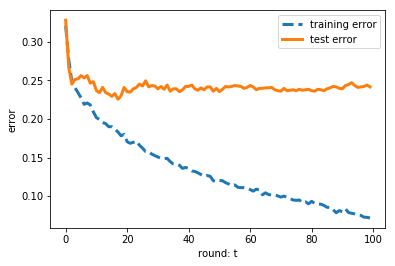

In [18]:
plt.xlabel('round: t')
plt.ylabel('error')
plt.plot(ada_tr_err[::10],label='training error',linestyle='dashed',lw=3)
plt.plot(ada_te_err[::10],label='test error',    linestyle='solid', lw=3)
plt.legend()
plt.show()

In [20]:
import xgboost as xgb          # xgboostを使う
# データ読込み
n = 4000
d = pd.read_csv('data/soldat.csv').values; d = np.delete(d,70,1)
i  = np.random.choice(len(d),n,replace=False)
ti = np.delete(np.arange(len(d)), i)
x, y = d[i,:71], d[i,71]
tx, ty = d[ti,:71], d[ti,71]
T = 1000                       # ラウンド数 1000
xg = xgb.XGBClassifier(n_estimators=T, max_depth=1, objective='binary:logistic')

xg.fit(x,y)                    # フィッティング
1-xg.score(tx,ty)              # テスト誤差

0.23605150214592274

In [21]:
xg = xgb.XGBClassifier(n_estimators=1000, max_depth=1, objective= 'binary:logistic')
cvx = x[:3500,:]; cvy = y[:3500];       # トレーニングデータ
eval_set = [(x[3500:,:], y[3500:])]    # 検証用のデータ
xg.fit(cvx, cvy, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set,verbose=True) # verboseを設定：途中経過をプリント

[0]	validation_0-logloss:0.67494
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.663866
[2]	validation_0-logloss:0.650502
[3]	validation_0-logloss:0.641174
[4]	validation_0-logloss:0.632024
[5]	validation_0-logloss:0.626014
[6]	validation_0-logloss:0.6187
[7]	validation_0-logloss:0.614404
[8]	validation_0-logloss:0.608655
[9]	validation_0-logloss:0.603559
[10]	validation_0-logloss:0.599429
[11]	validation_0-logloss:0.597102
[12]	validation_0-logloss:0.593414
[13]	validation_0-logloss:0.590661
[14]	validation_0-logloss:0.588863
[15]	validation_0-logloss:0.586012
[16]	validation_0-logloss:0.583897
[17]	validation_0-logloss:0.582829
[18]	validation_0-logloss:0.581178
[19]	validation_0-logloss:0.579685
[20]	validation_0-logloss:0.578658
[21]	validation_0-logloss:0.576264
[22]	validation_0-logloss:0.575066
[23]	validation_0-logloss:0.574417
[24]	validation_0-logloss:0.573423
[25]	validation_0-logloss:0.572647
[26]	validation_0-logloss:0.572112


[230]	validation_0-logloss:0.530295
[231]	validation_0-logloss:0.530212
[232]	validation_0-logloss:0.53033
[233]	validation_0-logloss:0.530416
[234]	validation_0-logloss:0.5303
[235]	validation_0-logloss:0.530194
[236]	validation_0-logloss:0.530142
[237]	validation_0-logloss:0.53013
[238]	validation_0-logloss:0.530132
[239]	validation_0-logloss:0.530081
[240]	validation_0-logloss:0.530331
[241]	validation_0-logloss:0.529983
[242]	validation_0-logloss:0.529927
[243]	validation_0-logloss:0.529738
[244]	validation_0-logloss:0.530042
[245]	validation_0-logloss:0.529888
[246]	validation_0-logloss:0.529755
[247]	validation_0-logloss:0.529776
[248]	validation_0-logloss:0.529789
[249]	validation_0-logloss:0.529828
[250]	validation_0-logloss:0.529737
[251]	validation_0-logloss:0.529841
[252]	validation_0-logloss:0.529727
[253]	validation_0-logloss:0.529848
[254]	validation_0-logloss:0.529803
[255]	validation_0-logloss:0.529863
[256]	validation_0-logloss:0.529243
[257]	validation_0-logloss:0.529

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [22]:
xg.best_iteration          # 最適なラウンド数

257

In [23]:
1-xg.score(tx,ty)          # テスト誤差

0.25321888412017168

In [24]:
xg.predict_proba(tx)      # 予測点における各ラベルの条件付き確率

array([[ 0.87767226,  0.12232777],
       [ 0.55203164,  0.44796836],
       [ 0.73098552,  0.26901448],
       ..., 
       [ 0.2073034 ,  0.7926966 ],
       [ 0.05452764,  0.94547236],
       [ 0.16084927,  0.83915073]], dtype=float32)